# Steg 1 - Data cleaning

- Jag tog bort bilder som:
  - Innehöll andra blommor i bilden.
  - inte hade en tydlig bild av blomman ifråga.
  - Där något annat var tydligt i fokus.
- Jag noterade att vissa blommor ofta har ett speciellt arrangemang. Exempelvis är det vanligt att stå bredvid en solros för att visa hur stor den är, att blåsa iväg frön från en vissen maskros, eller att ha rosor i en bukett. Jag lät ganska många sådana specialarrangemang vara kvar, även om det ibland blev mer fokus på en person i helfigur, snarare än solrosen. Om en person står i helfigur bredvid en blomma ska det förhoppningsvis vara en ledtråd till att det är en solros vi beskådar.

In [1]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.graph_objs as go
import seaborn as sns


In [2]:
# setting path to data
images_path = "data/flowers_cleaned"

In [3]:
# checking types of flowers
flowers_names = os.listdir(images_path)
flowers_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [4]:
# counting the types of flowers
flowers_images = []
for f in flowers_names:
    f_path = images_path + '/' + f
    flowers_images.append(len(os.listdir(f_path)))

In [5]:
fig = go.Figure()
fig.add_trace(go.Pie(labels = flowers_names, values = flowers_images, textinfo='label+percent', hoverinfo='label+value'))
fig.update_layout(title='Distribution Of Number Of Flowers Of Each Category')
fig.show()

In [6]:
dim_x = []
dim_y = []

for f in flowers_names:
    f_path =  images_path + '/' + f
    f_image_list = os.listdir(f_path)
    
    for i in f_image_list:
        x,y,z = imread(f_path + '/' + i).shape
        dim_x.append(x)
        dim_y.append(y)

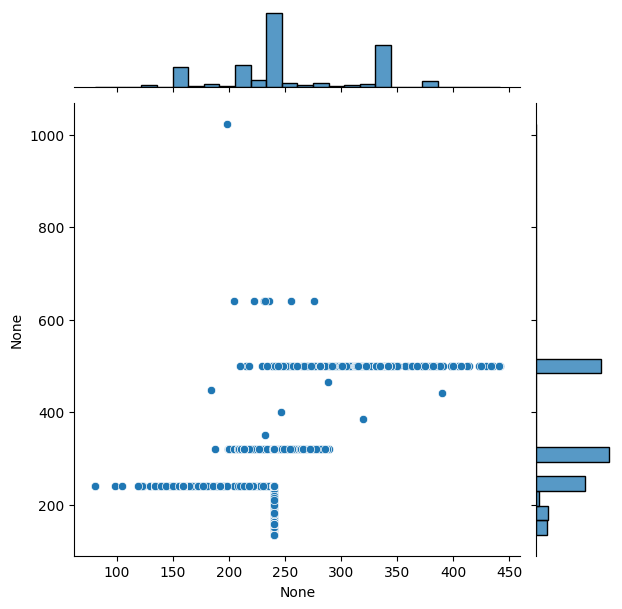

In [7]:
sns.jointplot(x=dim_x, y=dim_y)

In [8]:
print('Median Value For Dim X : ' + str(np.median(dim_x)))
print('Median Value For Dim Y : ' + str(np.median(dim_y)))

Median Value For Dim X : 240.0
Median Value For Dim Y : 320.0


In [9]:
# using split-folders to split the data into test, val and train
#import splitfolders
#splitfolders.ratio('Data/flowers_cleaned', output="Data/flowers_cleaned_split", seed=1337, ratio=(.7, 0.15,0.15)) 

In [10]:

from keras.preprocessing.image import ImageDataGenerator

image_shape = (240, 240, 3)
test_split_size = 0.15
batch_size = 128
rescale_factor = 1/255

# Define the parameters for data augmentation
train_datagen = ImageDataGenerator(
    rescale=rescale_factor,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create the training dataset
train_dataset = train_datagen.flow_from_directory(
    'data/flowers_cleaned_split/train',
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create the val dataset
val_dataset = validation_datagen.flow_from_directory(
    'data/flowers_cleaned_split/val/',
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create the test dataset
test_dataset = test_datagen.flow_from_directory(
    'data/flowers_cleaned_split/test/',
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


print(f'Number Of Images In Training Dataset : {str(train_dataset.samples)}')
print(f'Number Of Images In Validation Dataset : {str(val_dataset.samples)}')
print(f'Number Of Images In Validation Dataset : {str(test_dataset.samples)}')
print(f'Total number of images: {train_dataset.samples+val_dataset.samples+test_dataset.samples}')


Found 2915 images belonging to 5 classes.
Found 624 images belonging to 5 classes.
Found 628 images belonging to 5 classes.
Number Of Images In Training Dataset : 2915
Number Of Images In Validation Dataset : 624
Number Of Images In Validation Dataset : 628
Total number of images: 4167


In [11]:
train_dataset.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [12]:
# Defining Number Of Steps For Training & Validation Of Model
steps_per_epoch = train_dataset.samples // batch_size
validation_steps = val_dataset.samples // batch_size

print('Steps Per Epoch : Training -> ' + str(steps_per_epoch))
print('Steps : Validation -> ' + str(validation_steps))

Steps Per Epoch : Training -> 22
Steps : Validation -> 4


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation, BatchNormalization
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from pathlib import Path
from time import strftime

In [14]:
# callbacks

def get_run_logdir(custom_text="", root_logdir="my_logs"):
    formatted_time = strftime("run_%Y_%m_%d_%H_%M_%S")
    if custom_text:
        custom_text = "_" + custom_text
    return Path(root_logdir) / (formatted_time + custom_text)

run_logdir = get_run_logdir("added_1_more_conv")

tensorboard_cb = TensorBoard(run_logdir, profile_batch=(100, 200))

early_stop_cb = EarlyStopping(monitor='val_loss', patience=5)
run_logdir

WindowsPath('my_logs/run_2023_12_13_22_49_57_added_1_more_conv')

In [15]:
# create model
model = Sequential()

# add layers to model
model.add(
    Conv2D(
        filters=32,
        padding="same",
        kernel_size=(3, 3),
        input_shape=image_shape,
        # kernel_regularizer=regularizers.L2(1e-4),
        activation="relu"
    )
)
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(
    Conv2D(
        filters=32,
        padding="same",
        kernel_size=(3, 3),
        # kernel_regularizer=regularizers.L2(1e-4),
    )
)
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(
    Conv2D(
        filters=64,
        padding="same",
        kernel_size=(3, 3),
        # kernel_regularizer=regularizers.L2(1e-4),
    )
)
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(
    Conv2D(
        filters=64,
        padding="same",
        kernel_size=(3, 3),
        #kernel_regularizer=regularizers.L2(1e-4),
        activation="relu"
    )
)
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(
    Conv2D(
        filters=128,
        padding="same",
        kernel_size=(3, 3),
        # kernel_regularizer=regularizers.L2(1e-4),
    )
)
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(
    Conv2D(
        filters=128,
        padding="same",
        kernel_size=(3, 3),
        #kernel_regularizer=regularizers.L2(1e-4),
        activation="relu"
    )
)
model.add(
    Conv2D(
        filters=128,
        padding="same",
        kernel_size=(3, 3),
        #kernel_regularizer=regularizers.L2(1e-4),
        activation="relu"
    )
)
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(5, activation="softmax"))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 240, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 240, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 120, 120, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 120, 120, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 64)      36928     
                                                        

In [19]:
history = model.fit(train_dataset,epochs=10,steps_per_epoch = steps_per_epoch,
                    validation_data = val_dataset, validation_steps=validation_steps,
                    verbose=True, callbacks=[early_stop_cb, tensorboard_cb])

Epoch 1/10
22/22 [==============================] - 234s 10s/step - loss: 0.9453 - accuracy: 0.6319 - val_loss: 1.0058 - val_accuracy: 0.5859
Epoch 2/10
 5/22 [=====>........................] - ETA: 2:48 - loss: 0.9573 - accuracy: 0.6266

In [18]:
%load_ext tensorboard
%tensorboard --logdir=./mylogs

Reusing TensorBoard on port 6008 (pid 23112), started 17:29:23 ago. (Use '!kill 23112' to kill it.)